### Imports

In [12]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [13]:
buy_threshold = 5
sell_threshold = 5
starting_balance = 100000

run_optimizing = False
google_colab = False

### Data loading

In [14]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1-kLmDPAmiTHNw_cv3lr6wY9DfSt8RSHv"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('05-07_11-26.csv')  
    df = pd.read_csv('05-07_11-26.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))


    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/predictions/Ny modell run.csv')

### Data processing

In [15]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')
# Filter date
df = df[(df['Expiry_date'] <= '2017-12-31')]
#df = df.sample(1000)
df["Option_ID"] = df["Expiry_date"].astype(str) + "-" + df["Strike"].astype(str)

Adding TTM=0 row

In [16]:
# Convert Quote_date and Expiry_date to datetime before sorting
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Prepare new rows outside the loop
new_rows = df.groupby(['Expiry_date', 'Strike']).apply(lambda group: group.iloc[-1]).reset_index(drop=True)
new_rows['Price'] = np.maximum(0, new_rows['Underlying_last'] - new_rows['Strike'])
new_rows['TTM'] = 0
new_rows['Quote_date'] = new_rows['Expiry_date']

# Concatenate the new rows to the original dataframe
df = pd.concat([df, new_rows], ignore_index=True)

df_read = df.copy()

### Functions

In [17]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    sell_signal = (df['Price'] - df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance):
    df = df.copy()
    # Filter out options that expire before the last quote date
    df = df[pd.to_datetime(df['Expiry_date']) < pd.to_datetime(df['Quote_date'].max())]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Position_this_opt'] = 0
    df['Balance'] = starting_balance  # Initialize Balance column with starting_balance

    quote_date_grouped = df.groupby('Quote_date')

    balance = starting_balance

    for quote_date, group in quote_date_grouped:
        group = group.sample(frac=1)

        for _, row in group.iterrows():
            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and option_position == 0 and balance >= row['Price'] and row["Quote_date"] != row["Expiry_date"]:
                balance -= row['Price']
                option_position = 1
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Sell the option
            elif row['Signal'] == -1 and option_position == 1 and row["Quote_date"] != row["Expiry_date"] and balance > 0:
                balance += row['Price']
                option_position = 0
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Option expires
            elif row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position == 1 else -intrinsic_value
                balance += adjustment
                option_position = 0
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            df.loc[(df['Quote_date'] == quote_date) & (df['Position_this_opt'] == 0), 'Balance'] = balance
        
        # Print date and balance if quote_date is 1. january, 1. april, 1. july or 1. october
        if quote_date.month in [1, 4, 7, 10] and quote_date.day == 1:
            print("On, {}, the balance is: {}".format(quote_date, balance))

    return df





def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [22]:
def print_results(df, starting_balance):
    print("Starting balance", starting_balance)
    print("Ending balance", df['Balance'].iloc[-1])
    print("Number of trades", df['Signal'].abs().sum())
    profit = df['Balance'].iloc[-1] - starting_balance
    print("Profit", profit)
    print("Profit per trade", profit / df['Signal'].abs().sum())
    print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
    print("Number of days", num_days)

In [26]:
def sharpe_ratio(df):
    df = df.copy()
    # Group by Quote_date and keep the last row of each group
    df = df.groupby('Quote_date').last()
    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()
    # Convert the annual risk-free rate to a daily rate
    df['Daily_Rf'] = (1 + df['R'])**(1/252) - 1
    # Calculate the excess returns
    excess_returns = df['Daily_Returns'] - df['Daily_Rf']
    # Calculate sharpe ratio
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
    return sharpe_ratio

In [23]:
if run_optimizing == False:
    df = df_read.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

Starting balance 100000
Ending balance 98411.345
Number of trades 192
Profit -1588.6549999999988
Profit per trade -8.27424479166666
Profit per day -18.91255952380951
Number of days 84


### Analysis

In [24]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

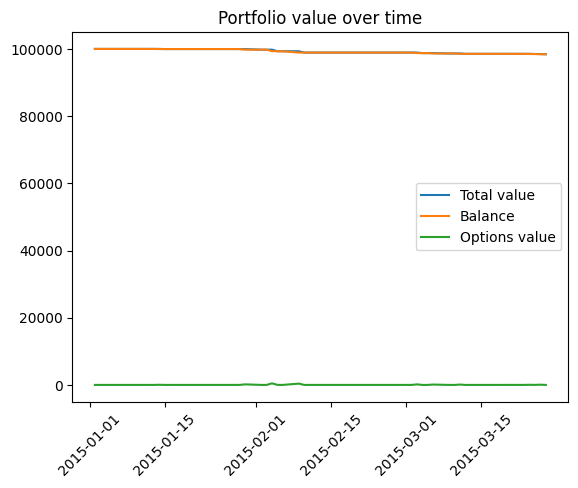

In [25]:
if run_optimizing == False:
    plot(df)

### Finding best thresholds

In [ ]:
if run_optimizing:
    # Initialize wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': 'Small dataset - New sharpe ratio',
    'metric': {
        'goal': 'maximize', 
        'name': 'sharpe_ratio'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.1, 1, 4, 8, 12]},
        'sell_threshold': {
            'values': [0.1, 1, 4, 8, 12]},
        'starting_balance': {
            'values': [100000, 1000000]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/hjalmarjacobvinje/.netrc


Create sweep with ID: dwzhgm8q
Sweep URL: https://wandb.ai/avogadro/options-trading/sweeps/dwzhgm8q


wandb: Agent Starting Run: bllt0c7f with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 0.1
starting_balance 100000
Ending balance 1.705000000030748
Number of trades 1385
sharpe_ratio -6.7762201697474245


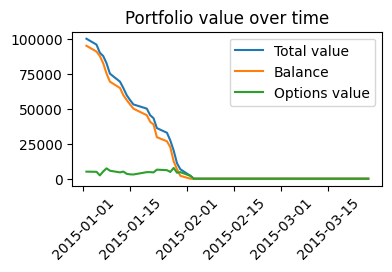

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,0.1
sharpe_ratio,-6.77622


wandb: Agent Starting Run: mkzl9ue6 with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 0.1
starting_balance 1000000
Ending balance 818574.5049999993
Number of trades 1385
sharpe_ratio -16.07061274058669


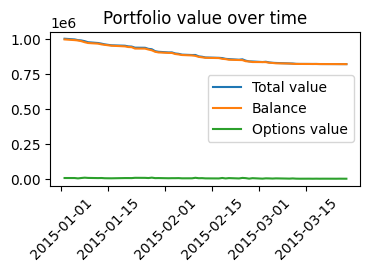

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,0.1
sharpe_ratio,-16.07061


wandb: Agent Starting Run: 2lqqbepr with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 1
starting_balance 100000
Ending balance 0.36500000003670596
Number of trades 1148
sharpe_ratio -6.952252679416189


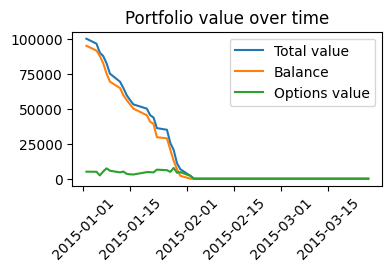

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,1
sharpe_ratio,-6.95225


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2dxyacat with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 1
starting_balance 1000000
Ending balance 818574.5049999993
Number of trades 1148
sharpe_ratio -17.65711575388413


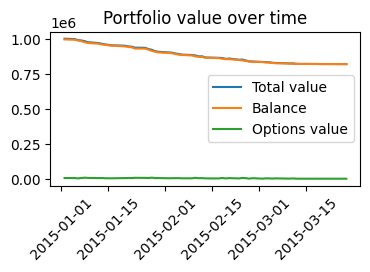

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,1
sharpe_ratio,-17.65712


wandb: Agent Starting Run: 3ze6bi8j with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 4
starting_balance 100000
Ending balance 1.620000000036839
Number of trades 926
sharpe_ratio -6.3503394957128165


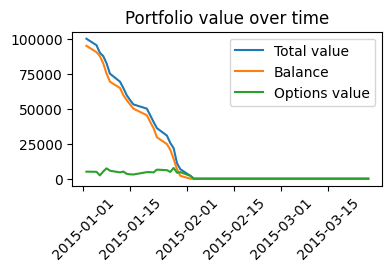

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,4
sharpe_ratio,-6.35034


wandb: Agent Starting Run: 8ipod392 with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 4
starting_balance 1000000
Ending balance 818574.5049999993
Number of trades 926
sharpe_ratio -17.658391313684067


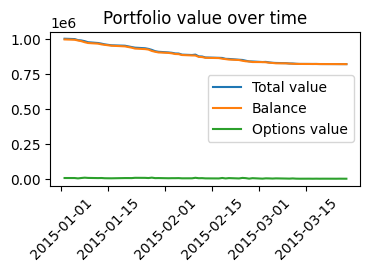

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,4
sharpe_ratio,-17.65839


wandb: Agent Starting Run: dfb1ntmr with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 8
starting_balance 100000
Ending balance 2.1050000000199773
Number of trades 870
sharpe_ratio -6.637452262430444


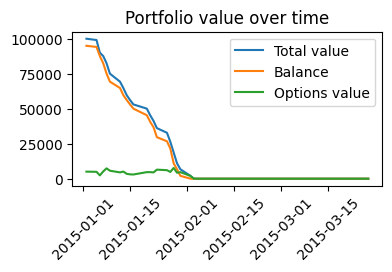

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,8
sharpe_ratio,-6.63745


wandb: Agent Starting Run: tsgk59qh with config:
wandb: 	buy_threshold: 0.1
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 0.1
sell_threshold 8
starting_balance 1000000
Ending balance 818574.5049999993
Number of trades 870
sharpe_ratio -17.92610948681993


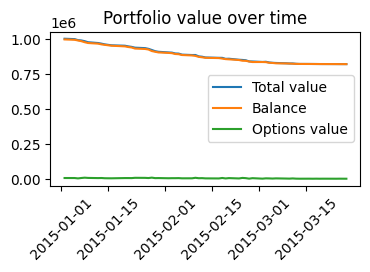

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,0.1
sell_threshold,8
sharpe_ratio,-17.92611


wandb: Agent Starting Run: 4xaz6o0p with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 0.1
starting_balance 100000
Ending balance 2.6350000000354115
Number of trades 1178
sharpe_ratio -8.853233358020859


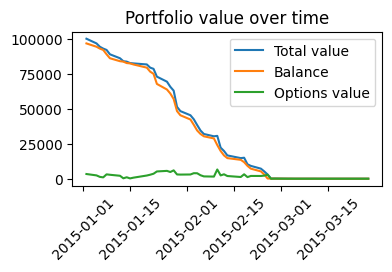

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,0.1
sharpe_ratio,-8.85323


wandb: Agent Starting Run: 12y0fi6w with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 0.1
starting_balance 1000000
Ending balance 887182.2449999994
Number of trades 1178
sharpe_ratio -15.907563727838761


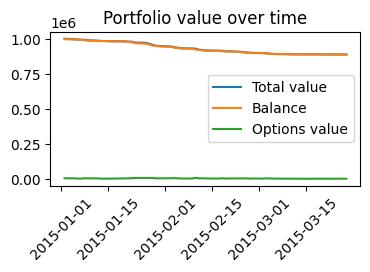

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,0.1
sharpe_ratio,-15.90756


wandb: Agent Starting Run: 49qkxrx4 with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 1
starting_balance 100000
Ending balance 2.6350000000370315
Number of trades 941
sharpe_ratio -8.4727178887118


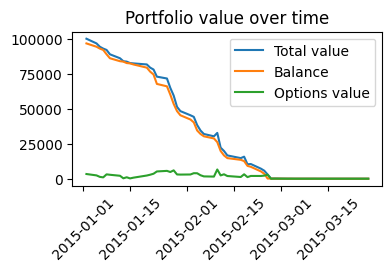

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,1
sharpe_ratio,-8.47272


wandb: Agent Starting Run: dxitzq4j with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 1
starting_balance 1000000
Ending balance 887182.2449999994
Number of trades 941
sharpe_ratio -13.292189630618058


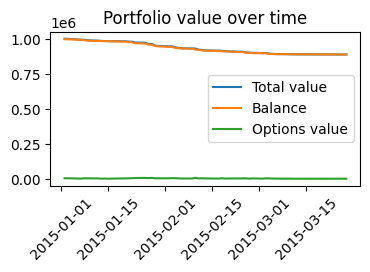

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,1
sharpe_ratio,-13.29219


wandb: Agent Starting Run: nx6mh4v5 with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 4
starting_balance 100000
Ending balance 5.990000000028219
Number of trades 719
sharpe_ratio -8.837640284547938


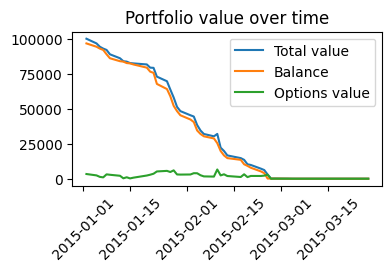

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,4
sharpe_ratio,-8.83764


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vx9hasb with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 4
starting_balance 1000000
Ending balance 887182.2449999994
Number of trades 719
sharpe_ratio -12.842128816447408


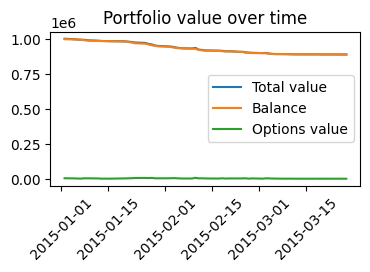

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,4
sharpe_ratio,-12.84213


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pp3vx8or with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 8
starting_balance 100000
Ending balance 2.6350000000276808
Number of trades 663
sharpe_ratio -8.125426208396274


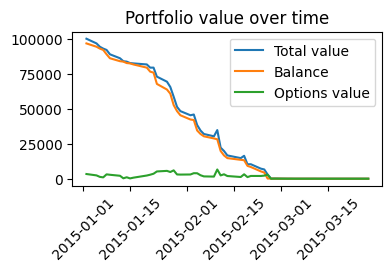

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,8
sharpe_ratio,-8.12543


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t1y2hvle with config:
wandb: 	buy_threshold: 1
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 1
sell_threshold 8
starting_balance 1000000
Ending balance 887182.2449999994
Number of trades 663
sharpe_ratio -15.719399301155647


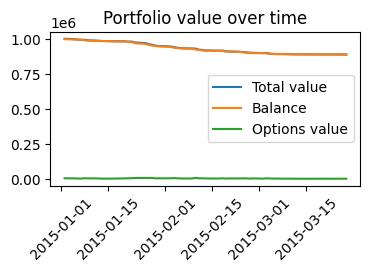

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,1
sell_threshold,8
sharpe_ratio,-15.7194


wandb: Agent Starting Run: 25sm6tv7 with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 0.1
starting_balance 100000
Ending balance 95761.85500000004
Number of trades 736
sharpe_ratio -10.148252286280698


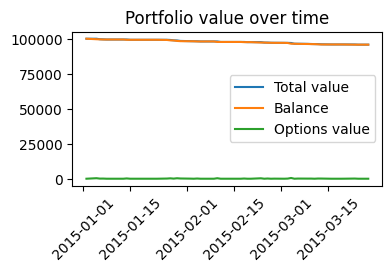

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,0.1
sharpe_ratio,-10.14825


wandb: Agent Starting Run: es6dnp3g with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 0.1
starting_balance 1000000
Ending balance 995761.8549999996
Number of trades 736
sharpe_ratio -10.240519727581395


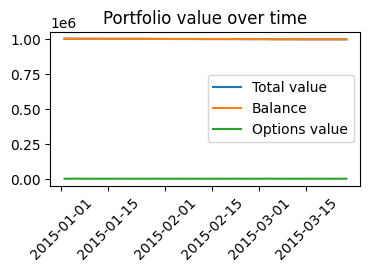

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,0.1
sharpe_ratio,-10.24052


wandb: Agent Starting Run: uu3ikr5j with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 1
starting_balance 100000
Ending balance 95761.85500000004
Number of trades 499
sharpe_ratio -10.148252286280698


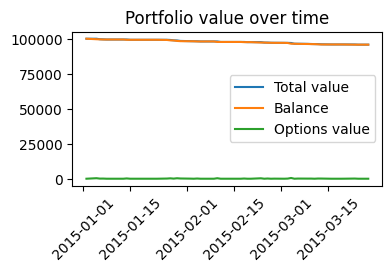

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,1
sharpe_ratio,-10.14825


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ctfrj9yr with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 1
starting_balance 1000000
Ending balance 995761.8549999996
Number of trades 499
sharpe_ratio -10.240519727581395


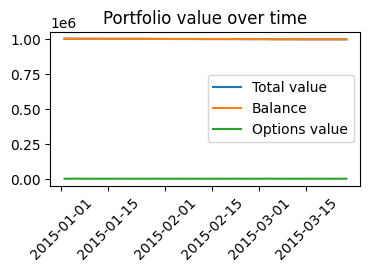

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,1
sharpe_ratio,-10.24052


wandb: Agent Starting Run: mes4i9vb with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 4
starting_balance 100000
Ending balance 95761.85500000004
Number of trades 277
sharpe_ratio -10.148252286280698


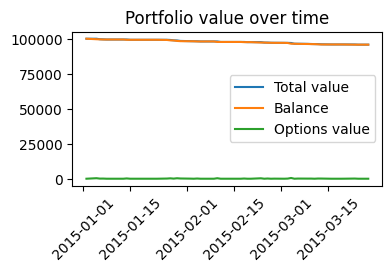

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,4
sharpe_ratio,-10.14825


wandb: Agent Starting Run: 6tahyv1j with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 4
starting_balance 1000000
Ending balance 995761.8549999996
Number of trades 277
sharpe_ratio -10.240519727581395


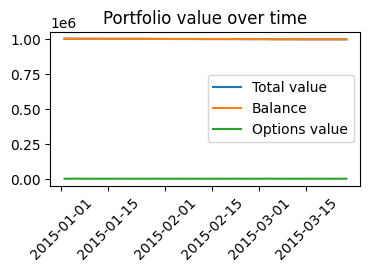

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,4
sharpe_ratio,-10.24052


wandb: Agent Starting Run: 5e23jkhb with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 8
starting_balance 100000
Ending balance 95761.85500000004
Number of trades 221
sharpe_ratio -10.148252286280698


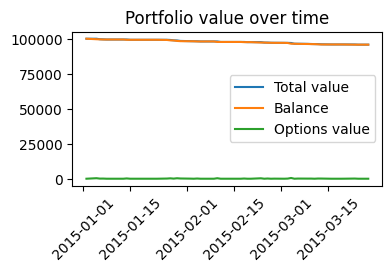

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,8
sharpe_ratio,-10.14825


wandb: Agent Starting Run: kohayxom with config:
wandb: 	buy_threshold: 4
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 4
sell_threshold 8
starting_balance 1000000
Ending balance 995761.8549999996
Number of trades 221
sharpe_ratio -10.240519727581395


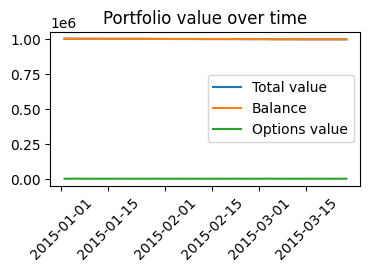

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,4
sell_threshold,8
sharpe_ratio,-10.24052


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jig1ee0f with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 0.1
starting_balance 100000
Ending balance 100000
Number of trades 635
sharpe_ratio -39.78292839781923


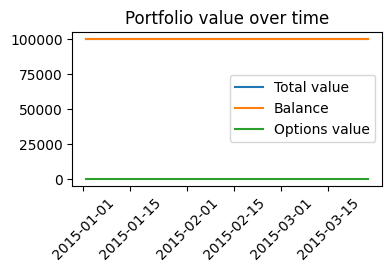

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,0.1
sharpe_ratio,-39.78293


wandb: Agent Starting Run: ti99pndt with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 0.1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 0.1
starting_balance 1000000
Ending balance 1000000
Number of trades 635
sharpe_ratio -39.78292839781923


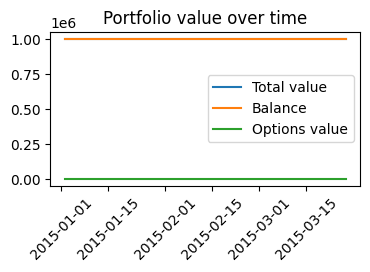

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,0.1
sharpe_ratio,-39.78293


wandb: Agent Starting Run: 4ygz96nr with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 1
starting_balance 100000
Ending balance 100000
Number of trades 398
sharpe_ratio -39.78292839781923


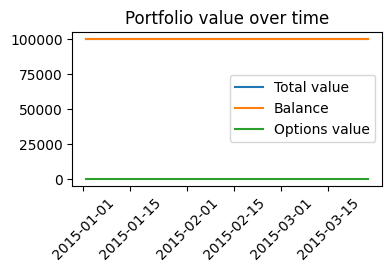

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,1
sharpe_ratio,-39.78293


wandb: Agent Starting Run: t3txbj1j with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 1
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 1
starting_balance 1000000
Ending balance 1000000
Number of trades 398
sharpe_ratio -39.78292839781923


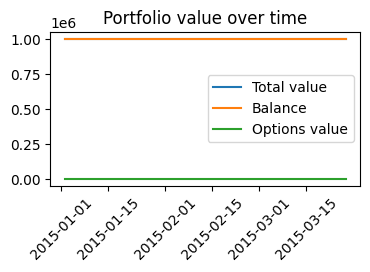

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,1
sharpe_ratio,-39.78293


wandb: Agent Starting Run: rnxzhued with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 4
starting_balance 100000
Ending balance 100000
Number of trades 176
sharpe_ratio -39.78292839781923


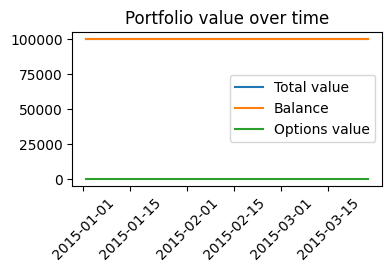

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,4
sharpe_ratio,-39.78293


wandb: Agent Starting Run: icbx84my with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 4
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 4
starting_balance 1000000
Ending balance 1000000
Number of trades 176
sharpe_ratio -39.78292839781923


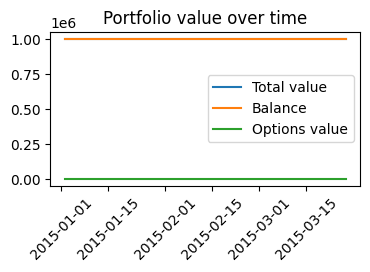

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,4
sharpe_ratio,-39.78293


wandb: Agent Starting Run: 1eskh6il with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 100000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 8
starting_balance 100000
Ending balance 100000
Number of trades 120
sharpe_ratio -39.78292839781923


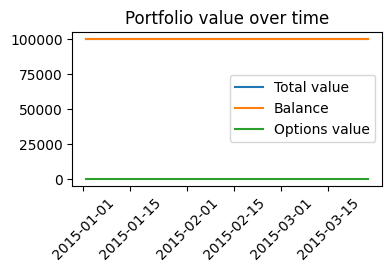

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,8
sharpe_ratio,-39.78293


wandb: Agent Starting Run: z1zqbpc7 with config:
wandb: 	buy_threshold: 8
wandb: 	sell_threshold: 8
wandb: 	starting_balance: 1000000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


buy_threshold 8
sell_threshold 8
starting_balance 1000000
Ending balance 1000000
Number of trades 120
sharpe_ratio -39.78292839781923


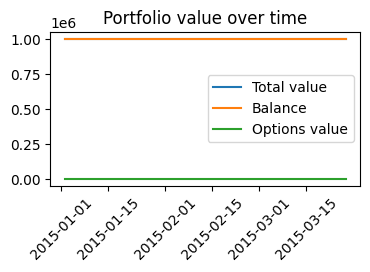

buy_threshold,▁
sell_threshold,▁
sharpe_ratio,▁
buy_threshold,8
sell_threshold,8
sharpe_ratio,-39.78293


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
if run_optimizing:
    def find_best_thresholds():
        run = wandb.init(project = "options-trading")
        df = df_read.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, run.config.starting_balance)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio(df)})
        # Wandb callback
        print("buy_threshold", run.config.buy_threshold)
        print("sell_threshold", run.config.sell_threshold)
        print("starting_balance", run.config.starting_balance)
        print("Ending balance", df['Balance'].iloc[-1])
        print("Number of trades", df['Signal'].abs().sum())
        print("sharpe_ratio", sharpe_ratio(df))
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)